In [15]:
import pandas
import math
import parse
import process
%load_ext Cython

#%%cython
########################################################
evidence_file = 'data/evidence.txt'
filtered_evidence_file = 'data/evidence_filtered.txt'
protein_groups_file = 'data/proteinGroups.txt'
phospho_peptide_file = 'data/Phospho (STY)Sites.txt'
our_group_name = 'PYND'
other_group_names = ['APUBSCRAWL', 'ONION', 'ET0H', 'SHMOO', 'WHANGEE'] # Case doesn't matter

experiment_ext_names = ['Ub', 'UbP', 'WCL', 'WCLP']


########################################################

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [16]:
# Now apply the filter to evidence.txt to get evidence_filtered.tsv
# This should keep only the lines for our group
parse.filter_tsv(evidence_file, filtered_evidence_file, 'Experiment', '^[Pp][Yy][Nn][Dd]')
print('Done.')

Done.


In [78]:
evidence = parse.parse_evidence(filtered_evidence_file)

protein_groups = parse.parse_protein_groups(protein_groups_file)
#protein_groups = parse.remove_cols(protein_groups, other_group_names)

phospho = parse.parse_phosphosites(phospho_peptide_file)
#phospho = parse.remove_cols(phospho, other_group_names) # TODO

/Users/student/anaconda/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (421,422) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/student/anaconda/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (211,677,678) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


Protein IDs                             object
Majority protein IDs                    object
Peptide counts (all)                    object
Peptide counts (razor+unique)           object
Peptide counts (unique)                 object
Fasta headers                           object
Number of proteins                       int64
Peptides                                 int64
Razor + unique peptides                  int64
Unique peptides                          int64
Peptides Apubscrawl_Cerulenin_Ub         int64
Peptides Apubscrawl_Cerulenin_UbP        int64
Peptides Apubscrawl_Cerulenin_WCL        int64
Peptides Apubscrawl_Cerulenin_WCLP       int64
Peptides Apubscrawl_Swe1KO_Ub            int64
Peptides Apubscrawl_Swe1KO_UbP           int64
Peptides Apubscrawl_Swe1KO_WCL           int64
Peptides Apubscrawl_Swe1KO_WCLP          int64
Peptides Control_Ub                      int64
Peptides Control_UbP                     int64
Peptides Control_WCL                     int64
Peptides Cont

In [21]:
def calc_epsilon(protein_groups):
    mins=[]
    for col in protein_groups.columns:
        for exp_ext in experiment_ext_names:
            if 'Intensity' in col and col.endswith(exp_ext):
                miny=float("inf")
                for x in protein_groups[col]:
                    x = float(x)
                    if x < miny and x != 0.0:
                        miny = x
                if miny != 0.0:
                    mins.append(miny)
    return min(mins)
epsilon = calc_epsilon(protein_groups)
epsilon

6193.8

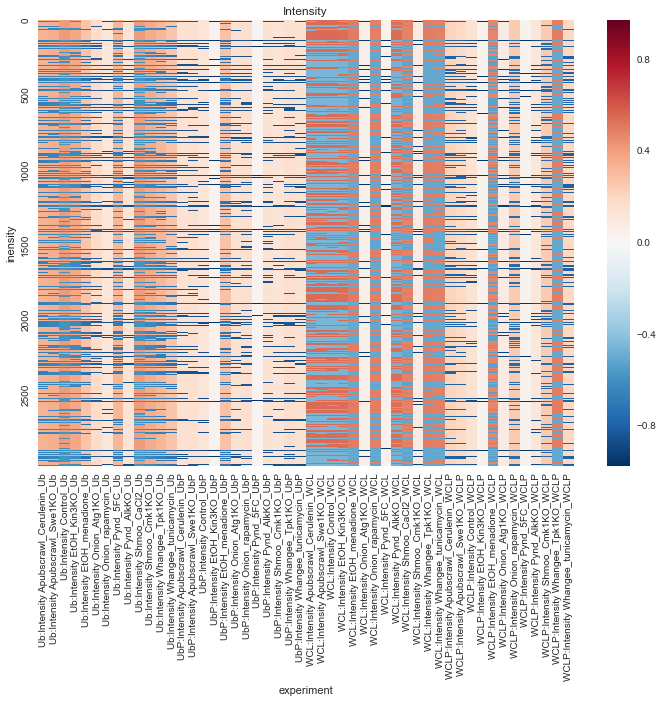

In [22]:
# What's the distribution of intensities?
def get_intensity_dists(protein_groups):
    dists={}
    for col in protein_groups.columns:
        for exp_ext in experiment_ext_names:
            if 'Intensity' in col and col.endswith(exp_ext):
                t = col.split('_')[-1] # to get sorting of keys right
                dists[t + ":" + col] = protein_groups[col].apply(lambda x: math.log(x, 2) if x > 0 else epsilon)
    return dists

dists = get_intensity_dists(protein_groups)

import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(rc={"figure.figsize": (12, 8)})
intensities = pandas.DataFrame(dists)
intensities = (intensities - intensities.mean()) / (intensities.max() - intensities.min())
sns.heatmap(intensities, yticklabels=500)
sns.axlabel("experiment", "inensity")
plt.title("Intensity")

In [ ]:
from scipy import stats, integrate
def plot_for_exp(dists, exp):
    for key, value in dists.items():
        lst = value != 0
        bandwidth = 2 * lst.std() * lst.size ** (-1 / 5.)
        if key.startswith(exp + ':') or 'Control' in exp:
            sns.kdeplot(lst, bw=bandwidth, label=key)
            #sns.distplot(lst, bins=200, kde=False, rug=False);
    sns.axlabel("intensity", "frequency")
    plt.title("Intensities for %s experiment" % exp)
    plt.show()
plot_for_exp(dists, 'WCL')
plot_for_exp(dists, 'WCLP')
plot_for_exp(dists, 'Ub')
plot_for_exp(dists, 'UbP')

In [207]:
def filter_bad_rows(df):

    def filter_out(prefix):
        return df[df.apply(lambda row: not any([prefix in name for name in row['Protein IDs']]), axis=1)]

    df = filter_out('CON_')
    df = filter_out('REV_')
    return df


pg = protein_groups.copy()
pg = filter_bad_rows(pg)

def normalize(pg, top_col, bottom_col):   
    pg = pg[pg[top_col] > 10 ** 5]
    pg = pg[pg[bottom_col] > 10 ** 5]
    pg['diff'] = pg[top_col] / pg[bottom_col]
    pg = pg[pg['diff'] < float('Inf')]
    pg = pg[pg['diff'] > 0]
    pg['diff'] = pg['diff'].map(lambda x: math.log(x, 2))
    return pg

def get_top(pg, file_name='top_genes.csv'):
    top = pg.sort('diff', 0, False)[:20]
    top.to_csv(file_name)
    return top[['Protein IDs', 'Fasta headers', 'diff']]
    
def get_bottom(pg, file_name='bottom_genes.csv'):
    bottom = pg.sort('diff', 0, True)[:20]
    bottom.to_csv(file_name)
    return bottom[['Protein IDs', 'Fasta headers', 'diff']]

pg = normalize(pg, 'Intensity Pynd_AlkKO_WCL', 'Intensity Control_WCL')

In [208]:
get_top(pg)

,Protein IDs,Fasta headers,diff
1416,[YIL022W],"[>YIL022W TIM44 SGDID:S000001284, Chr IX from ...",6.164958
915,[YER088C],"[>YER088C DOT6 SGDID:S000000890, Chr V from 33...",4.532620
710,[YDR296W],"[>YDR296W MHR1 SGDID:S000002704, Chr IV from 1...",4.055606
1737,[YKL128C],"[>YKL128C PMU1 SGDID:S000001611, Chr XI from 2...",3.452770
1672,[YJR148W],"[>YJR148W BAT2 SGDID:S000003909, Chr X from 70...",3.122075
2376,[YNL147W],"[>YNL147W LSM7 SGDID:S000005091, Chr XIV from ...",2.929512
1946,[YLR195C],"[>YLR195C NMT1 SGDID:S000004185, Chr XII from ...",2.784902
2142,[YML123C],"[>YML123C PHO84 SGDID:S000004592, Chr XIII fro...",2.559837
1824,[YKR084C],"[>YKR084C HBS1 SGDID:S000001792, Chr XI from 5...",2.453685
1507,[YJL005W],"[>YJL005W CYR1 SGDID:S000003542, Chr X from 42...",2.266395


In [209]:
get_bottom(pg)

,Protein IDs,Fasta headers,diff
964,[YER176W],"[>YER176W ECM32 SGDID:S000000978, Chr V from 5...",-9.108069
1745,[YKL148C],"[>YKL148C SDH1 SGDID:S000001631, Chr XI from 1...",-4.056005
346,[YBR234C],"[>YBR234C ARC40 SGDID:S000000438, Chr II from ...",-3.754898
469,[YDL060W],"[>YDL060W TSR1 SGDID:S000002218, Chr IV from 3...",-3.646610
447,[YDL004W],"[>YDL004W ATP16 SGDID:S000002162, Chr IV from ...",-3.634324
1023,[YFR047C],"[>YFR047C BNA6 SGDID:S000001943, Chr VI from 2...",-3.518659
1041,[YGL023C],"[>YGL023C PIB2 SGDID:S000002991, Chr VII from ...",-3.358856
1403,[YHR196W],"[>YHR196W UTP9 SGDID:S000001239, Chr VIII from...",-3.075066
1074,[YGL099W],"[>YGL099W LSG1 SGDID:S000003067, Chr VII from ...",-3.057144
1222,[YGR187C],"[>YGR187C HGH1 SGDID:S000003419, Chr VII from ...",-3.016709
